# 3D BPT Reprojection

### This is a notebook that plots Starforming and AGN models in a reprojected BPT diagram space

In [1]:
import numpy as np
import os
from scipy import interpolate

# libraries to plot 3d surfaces
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#libraries to read Ji & Yan's model grids
import glob
from astropy.io import fits

In [2]:
filename = 'centralflux.fits'
hdul = fits.open(filename)
centralflux_data = hdul[1].data

# see headers of fits file
hdr = hdul[1].header
#print(hdr)

## Standard BPT Diagram

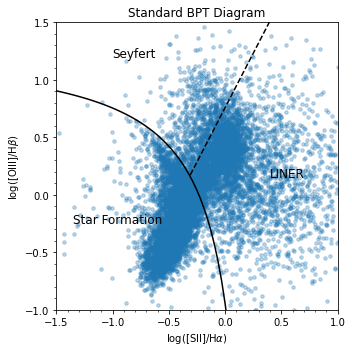

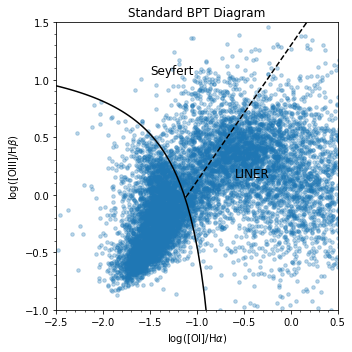

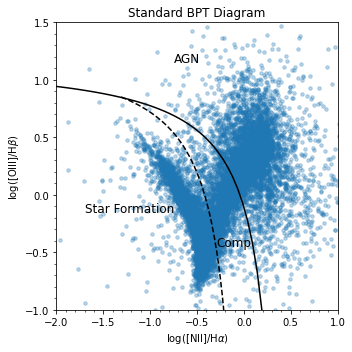

In [3]:
# Kewley (2006) lines
# first create a linspace of points to plot the classification lines
x_SII_sf = np.linspace(-1.5,0.065)
x_SII_sy_liner = np.linspace(-0.31,1.5)

x_NII_sf = np.linspace(-1.31, 0.045)
x_NII_comp = np.linspace(-2.2, 0.35)

x_OI_sf = np.linspace(-2.5, -0.7)
x_OI_sy_liner = np.linspace(-1.12, 0.5)

def starformation_SII(log_SII_Ha):
    """Star formation classification line for log([SII]/Ha)"""
    return 0.72/(log_SII_Ha - 0.32) + 1.30

def seyfert_liner_SII(log_SII_Ha):
    """Seyfert and LINER classification line for log([SII]/Ha)"""
    return 1.89 * log_SII_Ha + 0.76

def seyfert_liner_OI(log_OI_Ha):
    """Seyfert and LINER classification line for log([OI]/Ha)"""
    return 1.18 * log_OI_Ha + 1.30

def starformation_OI(log_OI_Ha):
    """Star formation classification line for log([OI]/Ha)"""
    return 0.73 / (log_OI_Ha + 0.59) + 1.33

def composite_NII(log_NII_Ha):
    """Composite galaxy classification line for log([NII]/Ha)"""
    return 0.61/(log_NII_Ha - 0.47) + 1.19

def starformation_NII(log_NII_Ha):
    """Composite galaxy and LINER classification line for log([NII]/Ha)"""
    return 0.61 / (log_NII_Ha - 0.05) + 1.3

#log([OIII]/H-beta)/([SII]/H-alpha)
plt.figure(figsize = (5,5))
plt.scatter(centralflux_data['log_SII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'],  s = 50, alpha = 0.3, marker ='.', linestyle = 'None')
plt.plot(x_SII_sf, starformation_SII(x_SII_sf), '-k')
plt.plot(x_SII_sy_liner, seyfert_liner_SII(x_SII_sy_liner), '--k')
plt.text(-1,1.2, 'Seyfert', fontsize = 12)
plt.text(-1.35,-0.25, 'Star Formation', fontsize = 12)
plt.text(0.4, 0.15, 'LINER', fontsize = 12)

plt.title('Standard BPT Diagram')
plt.xlabel(r'log([SII]/H${\alpha}$)')
plt.ylabel(r'log([OIII]/H${\beta}$)')
plt.xlim(-1.5,1.0)
plt.ylim(-1.0,1.5)
plt.tight_layout()
plt.minorticks_on()
plt.savefig('BPT_SII_Ha_OIII_Hb.png')
plt.show()

#log([OIII]/H-beta) & ([OI]/H-alpha)
plt.figure(figsize = (5,5))
plt.scatter(centralflux_data['log_OI_Ha_cf'], centralflux_data['log_OIII_Hb_cf'],  s = 50, alpha = 0.3, marker ='.', linestyle = 'None')
plt.plot(x_OI_sf, starformation_OI(x_OI_sf), '-k')
plt.plot(x_OI_sy_liner, seyfert_liner_OI(x_OI_sy_liner), '--k')
plt.text(-1.5,1.05, 'Seyfert', fontsize = 12)
plt.text(-0.6, 0.15, 'LINER', fontsize = 12)

plt.title('Standard BPT Diagram')
plt.xlabel(r'log([OI]/H${\alpha}$)')
plt.ylabel(r'log([OIII]/H${\beta}$)')
plt.xlim(-2.5,0.5)
plt.ylim(-1.0,1.5)
plt.tight_layout()
plt.minorticks_on()
plt.savefig('BPT_OI_Ha_OIII_Hb.png')
plt.show()

#log([OIII]/H-beta) & ([NII]/H-alpha)
plt.figure(figsize = (5,5))
plt.scatter(centralflux_data['log_NII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'],  s = 50, alpha = 0.3, marker ='.', linestyle = 'None')
plt.plot(x_NII_sf, starformation_NII(x_NII_sf), '--k')
plt.plot(x_NII_comp, composite_NII(x_NII_comp), '-k')
plt.text(-0.75,1.15, 'AGN', fontsize = 12)
plt.text(-1.7,-0.15, 'Star Formation', fontsize = 12)
plt.text(-0.29, -0.45, 'Comp', fontsize = 12)

plt.title('Standard BPT Diagram')
plt.xlabel(r'log([NII]/H${\alpha}$)')
plt.ylabel(r'log([OIII]/H${\beta}$)')
plt.xlim(-2.0,1.0)
plt.ylim(-1.0,1.5)
plt.tight_layout()
plt.minorticks_on()
plt.savefig('BPT_NII_Ha_OIII_Hb.png')
plt.show()

# Ji & Yan (2020) BPT Model

In [4]:
'''
INPUT: modelname: directory + prefix of the model
You can modify the line ratios you want within the function
'''
def read_model(modelname):
    # Load photoionization model grids
    nameList = []
    n_model = len(glob.glob(modelname+'*'))
    for i in range(n_model):
        nameList += [modelname+str(i)+'_line.fits']
        
    # initialize arrays to hold our line ratio calculations
    o3hb_flat = np.array([])
    n2ha_flat = np.array([])
    s2ha_flat = np.array([])
    n2o2_flat = np.array([])
    o3o2_flat = np.array([])

    for name in nameList:
        hdu = fits.open(name)
        # extract emission line fluxes
        o3_flat = hdu[1].data['O__3__5006']
        hb_flat = hdu[1].data['H__1__4861']
        n2_flat = hdu[1].data['N__2__6583']
        ha_flat = hdu[1].data['H__1__6562']
        s2_flat = hdu[1].data['S__2__6716'] + hdu[1].data['S__2__6730']
        o2_flat = hdu[1].data['BLND__3727']

        
        # line ratios
        o3hb = np.log10(o3_flat/hb_flat)
        n2ha = np.log10(n2_flat/ha_flat)
        s2ha = np.log10(s2_flat/ha_flat)
        o3o2 = np.log10(o3_flat/o2_flat)
        n2o2 = np.log10(n2_flat/o2_flat)
 
        o3hb_flat = np.append(o3hb_flat, o3hb) # appending o3hb line ratio to our initialized array (o3hb flat)
        n2ha_flat = np.append(n2ha_flat, n2ha)
        s2ha_flat = np.append(s2ha_flat, s2ha)
        o3o2_flat = np.append(o3o2_flat, o3o2)
        n2o2_flat = np.append(n2o2_flat, n2o2)
        
    o3hb_final = o3hb_flat.reshape(n_model, -1)
    n2ha_final = n2ha_flat.reshape(n_model, -1)
    s2ha_final = s2ha_flat.reshape(n_model, -1)
    o3o2_final = o3o2_flat.reshape(n_model, -1)
    n2o2_final = n2o2_flat.reshape(n_model, -1)
    
    return o3hb_final, n2ha_final, s2ha_final, o3o2_final, n2o2_final

## Starforming Model (metallicities ranging from $ -4.0 $ to $-1.5$ in increments of $0.25$)

In [5]:
filename =  os.getcwd() + '/SF_Models/stb99_c4my_extraplin_0_line.fits'
n_model = len(glob.glob(filename))
hdul = fits.open(filename)
data = hdul[1].data

hdr = hdul[1].header
#print(hdr)

In [6]:
path_SF = os.getcwd() + '/SF_Models/stb99_c4my_extraplin_'
o3hb_final, n2ha_final, s2ha_final, o3o2_final, n2o2_final = read_model(path_SF)

In [7]:
print(n2ha_final.shape) # [metallicity, ionization]

(6, 11)


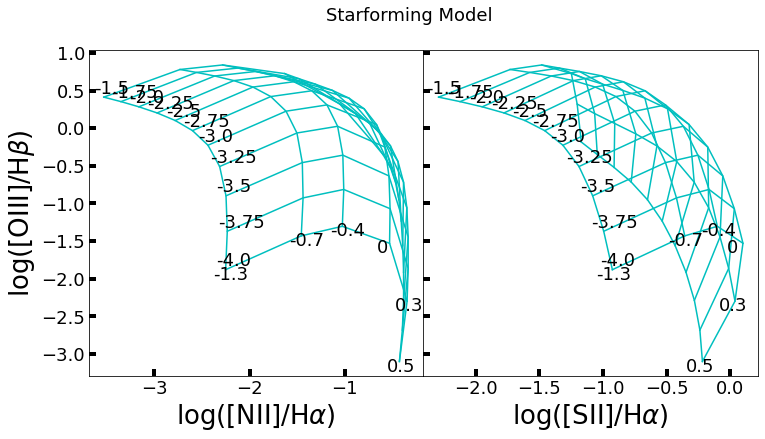

In [8]:
# Plot the model in two BPT diagrams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('Starforming Model ', fontsize= 18)

for i in range(n2ha_final.shape[0]): #metallicities
    axes[0].plot(n2ha_final[i], o3hb_final[i], color='c', lw=1.5)
    axes[1].plot(s2ha_final[i], o3hb_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #ionization
    axes[0].plot(n2ha_final[:,j], o3hb_final[:,j], color='c', lw=1.5)
    axes[1].plot(s2ha_final[:,j], o3hb_final[:,j], color='c', lw=1.5)
    
q_text = np.linspace(-4., -1.5, 11, dtype='str')
z_text = ['-1.3', '-0.7', '-0.4', '0', '0.3', '0.5']

for k in range(11): #ionization
    axes[0].text((n2ha_final[0][k])-0.1, (o3hb_final[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
    axes[1].text((s2ha_final[0][k])-0.1, (o3hb_final[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
    
for l in range(6): #metallicity
    axes[0].text((n2ha_final[:,0][l])-0.13, (o3hb_final[:,0][l])-0.13, 
                 str(z_text[l]),
                 fontsize=18)
    axes[1].text((s2ha_final[:,0][l])-0.13, (o3hb_final[:,0][l])-0.13, 
                 str(z_text[l]),
                 fontsize=18)


## Interpolate SF Model:

In [9]:
SF_ion_pars = np.linspace(-4, -1.5, 11)
SF_metal_pars = np.asarray([-1.3, -0.7, -0.4, 0, 0.3, 0.5])

f_o3hb = interpolate.interp2d(SF_ion_pars, SF_metal_pars, o3hb_final, kind='linear')
f_n2ha = interpolate.interp2d(SF_ion_pars, SF_metal_pars, n2ha_final, kind='linear')
f_s2ha = interpolate.interp2d(SF_ion_pars, SF_metal_pars, s2ha_final, kind='linear')

In [10]:
new_ion = np.linspace(-4.5, -2.0, 20)
new_metal = np.linspace(-1.3, 0.75, 15)

new_o3hb = f_o3hb(new_ion, new_metal)
new_n2ha = f_n2ha(new_ion, new_metal)
new_s2ha = f_s2ha(new_ion, new_metal)

In [11]:
print(new_o3hb.shape) # [metallicities, ionization]

(15, 20)


In [12]:
print('Interpolated Ionization Pars: ', new_ion)
print('Interpolated Metallicity Pars: ', new_metal)

Interpolated Ionization Pars:  [-4.5        -4.36842105 -4.23684211 -4.10526316 -3.97368421 -3.84210526
 -3.71052632 -3.57894737 -3.44736842 -3.31578947 -3.18421053 -3.05263158
 -2.92105263 -2.78947368 -2.65789474 -2.52631579 -2.39473684 -2.26315789
 -2.13157895 -2.        ]
Interpolated Metallicity Pars:  [-1.3        -1.15357143 -1.00714286 -0.86071429 -0.71428571 -0.56785714
 -0.42142857 -0.275      -0.12857143  0.01785714  0.16428571  0.31071429
  0.45714286  0.60357143  0.75      ]


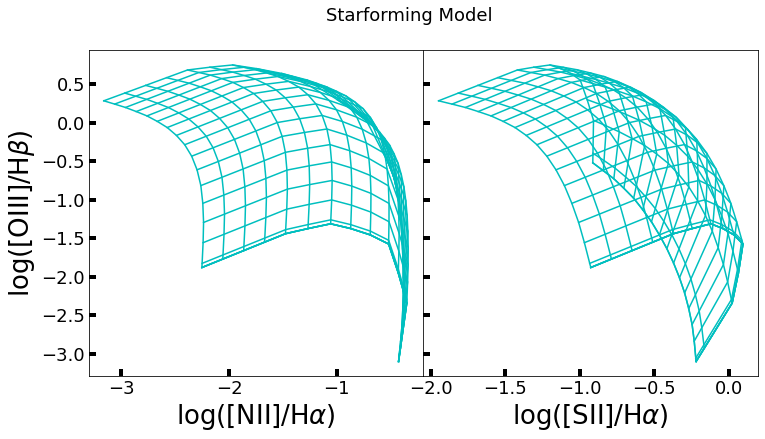

In [13]:
# Plot the model in two BPT diagrams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('Starforming Model ', fontsize= 18)

for i in range(new_n2ha.shape[0]): #metallicities --> horizontal
    axes[0].plot(new_n2ha[i], new_o3hb[i], color='c', lw=1.5)
    axes[1].plot(new_s2ha[i], new_o3hb[i], color='c', lw=1.5)
    
for j in range(new_n2ha.shape[1]): #ionization --> vertical
    axes[0].plot(new_n2ha[:,j], new_o3hb[:,j], color='c', lw=1.5)
    axes[1].plot(new_s2ha[:,j], new_o3hb[:,j], color='c', lw=1.5)

## AGN model (power law SED with a slope of -1.4)

In [14]:
path_1d4 = os.getcwd() + '/AGNm1d4_models/bplm1d4_hden2_gro_'

o3hb_final_1d4, n2ha_final_1d4, s2ha_final_1d4, o3o2_final_1d4, n2o2_1d4_final = read_model(path_1d4)

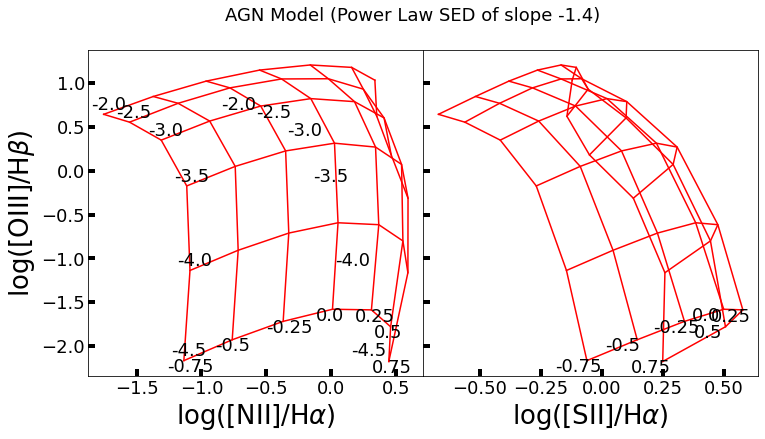

In [15]:
# Plot the model in two BPT diagrams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('AGN Model (Power Law SED of slope -1.4)', fontsize= 18)


for i in range(n2ha_final_1d4.shape[0]): #metallicities
    axes[0].plot(n2ha_final_1d4[i], o3hb_final_1d4[i], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d4[i], o3hb_final_1d4[i], color='r', lw=1.5)
    
for j in range(n2ha_final_1d4.shape[1]): #ionization
    axes[0].plot(n2ha_final_1d4[:,j], o3hb_final_1d4[:,j], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d4[:,j], o3hb_final_1d4[:,j], color='r', lw=1.5)
    
q_text_1d4 = np.linspace(-4.5, -2., 6, dtype='str')
z_text_1d4 = np.linspace(-.75, .75, 7, dtype='str')
for k in range(6):
    axes[0].text((n2ha_final_1d4[0][k])-0.1, (o3hb_final_1d4[0][k])+0.05, 
                 str(q_text_1d4[k]),
                 fontsize=18)
    axes[1].text((s2ha_final[0][k])-0.1, (o3hb_final_1d4[0][k])+0.05, 
                 str(q_text_1d4[k]),
                 fontsize=18)
for l in range(7):
    axes[0].text((n2ha_final_1d4[:,0][l])-0.13, (o3hb_final_1d4[:,0][l])-0.13, 
                 str(z_text_1d4[l]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d4[:,0][l])-0.13, (o3hb_final_1d4[:,0][l])-0.13, 
                 str(z_text_1d4[l]),
                 fontsize=18)

## AGN model (power law SED with a slope of -1.7)

In [16]:
path_1d7 = os.getcwd() + '/AGNm1d7_models/bplm1d7_fel_segro_'

o3hb_final_1d7, n2ha_final_1d7, s2ha_final_1d7, o3o2_final_1d7, n2o2_final_1d7 = read_model(path_1d7)

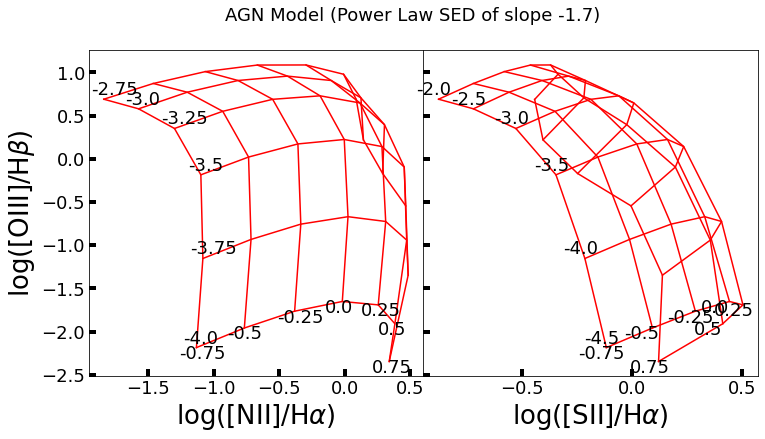

In [17]:
# Plot the model in two BPT diagrams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('AGN Model (Power Law SED of slope -1.7)', fontsize= 18)

for i in range(n2ha_final_1d7.shape[0]):
    axes[0].plot(n2ha_final_1d7[i], o3hb_final_1d7[i], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d7[i], o3hb_final_1d7[i], color='r', lw=1.5)
for j in range(n2ha_final_1d7.shape[1]):
    axes[0].plot(n2ha_final_1d7[:,j], o3hb_final_1d7[:,j], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d7[:,j], o3hb_final_1d7[:,j], color='r', lw=1.5)
    
q_text_1d7 = np.linspace(-4.5, -2., 6, dtype='str')
z_text_1d7 = np.linspace(-.75, .75, 7, dtype='str')

for k in range(6):
    axes[0].text((n2ha_final_1d7[0][k])-0.1, (o3hb_final_1d7[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d7[0][k])-0.1, (o3hb_final_1d7[0][k])+0.05, 
                 str(q_text_1d7[k]),
                 fontsize=18)
for l in range(7):
    axes[0].text((n2ha_final_1d7[:,0][l])-0.13, (o3hb_final_1d7[:,0][l])-0.13, 
                 str(z_text_1d7[l]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d7[:,0][l])-0.13, (o3hb_final_1d7[:,0][l])-0.13, 
                 str(z_text_1d7[l]),
                 fontsize=18)

## Interpolate AGN Models:

In [18]:
agn_ion_pars = np.linspace(-4.5, -2., 6)
agn_metal_pars = np.linspace(-.75, .75, 7)

f_o3hb_1d4 = interpolate.interp2d(agn_ion_pars, agn_metal_pars, o3hb_final_1d4, kind='linear')
f_n2ha_1d4 = interpolate.interp2d(agn_ion_pars, agn_metal_pars, n2ha_final_1d4, kind='linear')
f_s2ha_1d4 = interpolate.interp2d(agn_ion_pars, agn_metal_pars, s2ha_final_1d4, kind='linear')

f_o3hb_1d7 = interpolate.interp2d(agn_ion_pars, agn_metal_pars, o3hb_final_1d7, kind='linear')
f_n2ha_1d7 = interpolate.interp2d(agn_ion_pars, agn_metal_pars, n2ha_final_1d7, kind='linear')
f_s2ha_1d7 = interpolate.interp2d(agn_ion_pars, agn_metal_pars, s2ha_final_1d7, kind='linear')

In [19]:
new_ion = np.linspace(-4.5, -2., 20) #interpolate ionization to have 20 grid points
new_metal = np.linspace(-1.3, .75, 15) #interpolate metallicity to have 15 grid points

new_o3hb_1d4 = f_o3hb_1d4(new_ion, new_metal)
new_n2ha_1d4 = f_n2ha_1d4(new_ion, new_metal)
new_s2ha_1d4 = f_s2ha_1d4(new_ion, new_metal)

new_o3hb_1d7 = f_o3hb_1d7(new_ion, new_metal)
new_n2ha_1d7 = f_n2ha_1d7(new_ion, new_metal)
new_s2ha_1d7 = f_s2ha_1d7(new_ion, new_metal)

In [20]:
print(new_o3hb_1d4.shape) #[metallicity, ionization]

(15, 20)


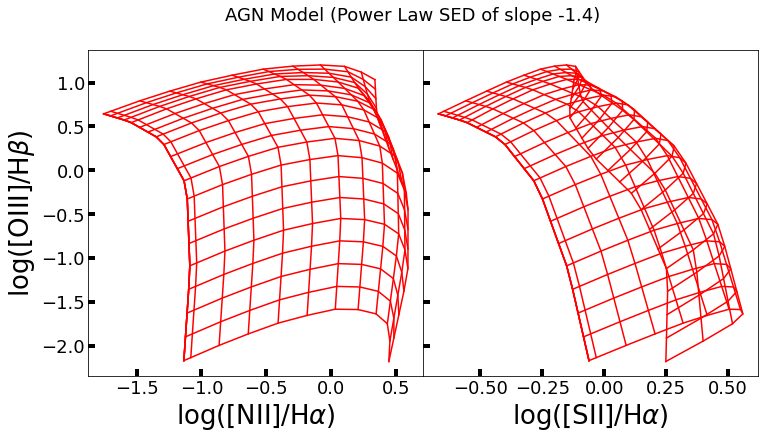

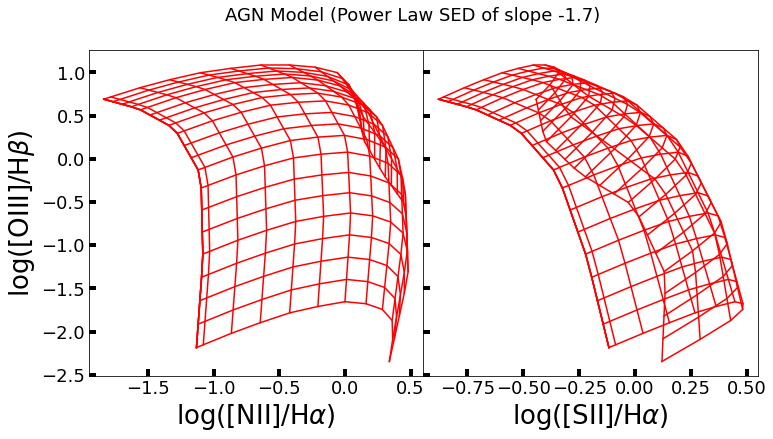

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('AGN Model (Power Law SED of slope -1.4)', fontsize= 18)

for i in range(new_n2ha_1d4.shape[0]): #metallicity
    axes[0].plot(new_n2ha_1d4[i], new_o3hb_1d4[i], color='r', lw=1.5)
    axes[1].plot(new_s2ha_1d4[i], new_o3hb_1d4[i], color='r', lw=1.5)
    
for j in range(new_n2ha_1d4.shape[1]): #ionization
    axes[0].plot(new_n2ha_1d4[:,j], new_o3hb_1d4[:,j], color='r', lw=1.5)
    axes[1].plot(new_s2ha_1d4[:,j], new_o3hb_1d4[:,j], color='r', lw=1.5)
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('AGN Model (Power Law SED of slope -1.7)', fontsize= 18)

for i in range(new_n2ha_1d7.shape[0]): #metallicity
    axes[0].plot(new_n2ha_1d7[i], new_o3hb_1d7[i], color='r', lw=1.5)
    axes[1].plot(new_s2ha_1d7[i], new_o3hb_1d7[i], color='r', lw=1.5)
    
for j in range(new_n2ha_1d7.shape[1]): #ionization
    axes[0].plot(new_n2ha_1d7[:,j], new_o3hb_1d7[:,j], color='r', lw=1.5)
    axes[1].plot(new_s2ha_1d7[:,j], new_o3hb_1d7[:,j], color='r', lw=1.5)

# BPT diagram of central flux measurements of our galaxy sample with the interpolated models

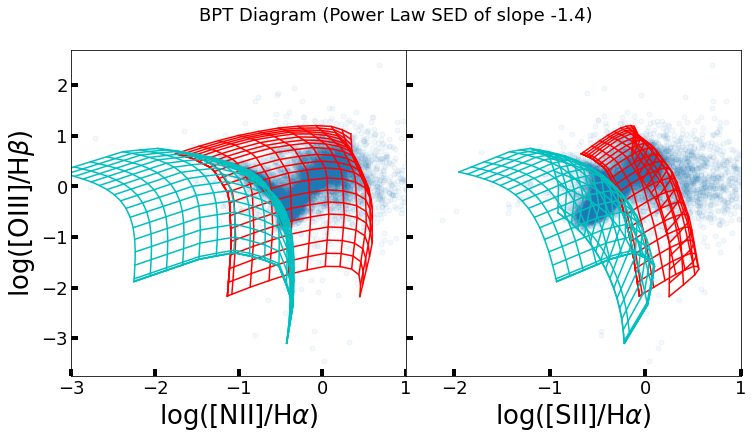

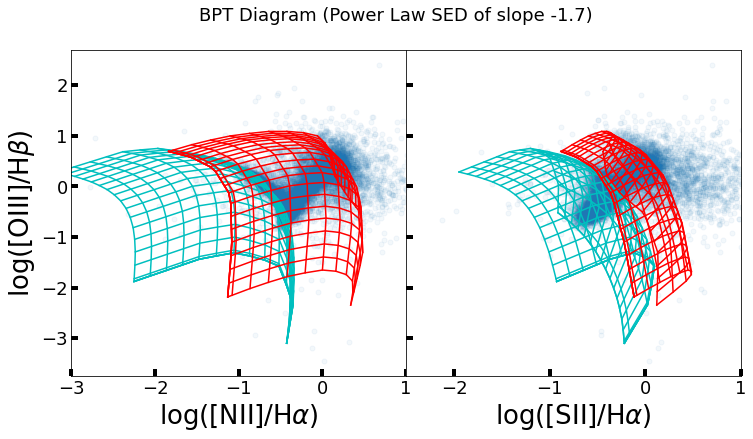

In [22]:
# -1.4 POWER LAW SLOPE AGN MODEL

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('BPT Diagram (Power Law SED of slope -1.4)', fontsize= 18)

for i in range(new_n2ha_1d4.shape[0]):
    axes[0].plot(new_n2ha_1d4[i], new_o3hb_1d4[i], color='r', lw=1.5)
    axes[1].plot(new_s2ha_1d4[i], new_o3hb_1d4[i], color='r', lw=1.5)
for j in range(new_n2ha_1d4.shape[1]):
    axes[0].plot(new_n2ha_1d4[:,j], new_o3hb_1d4[:,j], color='r', lw=1.5)
    axes[1].plot(new_s2ha_1d4[:,j], new_o3hb_1d4[:,j], color='r', lw=1.5)
    
    
# STARFORMING MODEL
for i in range(new_n2ha.shape[0]):
    axes[0].plot(new_n2ha[i], new_o3hb[i], color='c', lw=1.5)
    axes[1].plot(new_s2ha[i], new_o3hb[i], color='c', lw=1.5)
for j in range(new_n2ha.shape[1]):
    axes[0].plot(new_n2ha[:,j], new_o3hb[:,j], color='c', lw=1.5)
    axes[1].plot(new_s2ha[:,j], new_o3hb[:,j], color='c', lw=1.5)
    

# CENTRALFLUX DATA

axes[0].scatter(centralflux_data['log_NII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[0].set_xlim(-3.0,1.0)
axes[1].scatter(centralflux_data['log_SII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[1].set_xlim(-2.5,1.0)

# -1.7 POWER LAW SLOPE AGN MODEL
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('BPT Diagram (Power Law SED of slope -1.7)', fontsize= 18)

# STARFORMING MODEL
for i in range(new_n2ha.shape[0]):
    axes[0].plot(new_n2ha[i], new_o3hb[i], color='c', lw=1.5)
    axes[1].plot(new_s2ha[i], new_o3hb[i], color='c', lw=1.5)
    
for j in range(new_n2ha.shape[1]):
    axes[0].plot(new_n2ha[:,j], new_o3hb[:,j], color='c', lw=1.5)
    axes[1].plot(new_s2ha[:,j], new_o3hb[:,j], color='c', lw=1.5)

# CENTRALFLUX DATA
axes[0].scatter(centralflux_data['log_NII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[0].set_xlim(-3.0, 1.0)
axes[1].scatter(centralflux_data['log_SII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[1].set_xlim(-2.5, 1.0)

for i in range(new_n2ha_1d7.shape[0]):
    axes[0].plot(new_n2ha_1d7[i], new_o3hb_1d7[i], color='r', lw=1.5)
    axes[1].plot(new_s2ha_1d7[i], new_o3hb_1d7[i], color='r', lw=1.5)
for j in range(new_n2ha_1d7.shape[1]):
    axes[0].plot(new_n2ha_1d7[:,j], new_o3hb_1d7[:,j], color='r', lw=1.5)
    axes[1].plot(new_s2ha_1d7[:,j], new_o3hb_1d7[:,j], color='r', lw=1.5)
    
plt.show()

# Determining P1 and P2 Plane

(-0.7, 0.7)

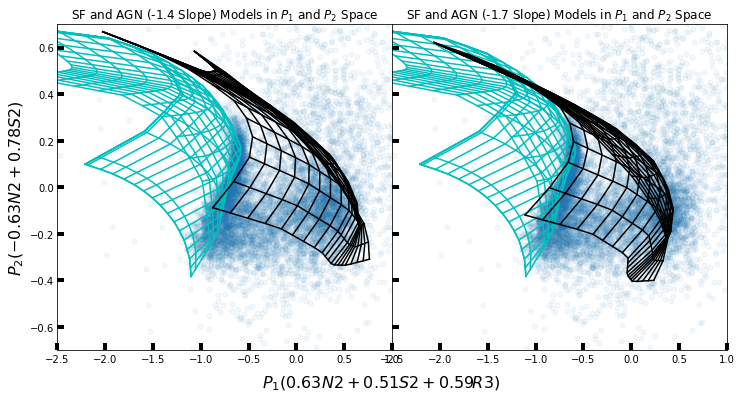

In [23]:
# P1 and P2 Plane
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=10, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=10, width=4., length=7., direction='in')

fig.text(0.5, 0.04, '$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', ha='center', fontsize = 16)
axes[0].set_ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=16)
axes[0].set_title('SF and AGN (-1.4 Slope) Models in $P_{1}$ and $P_{2}$ Space', fontsize= 12)
axes[1].set_title('SF and AGN (-1.7 Slope) Models in $P_{1}$ and $P_{2}$ Space', fontsize= 12)

# Starforming Model
for i in range(new_n2ha.shape[0]): #metallicity
    axes[0].plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i],-0.63*new_n2ha[i] + 0.78*new_s2ha[i], color='c', lw=1.5)
    axes[1].plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i],-0.63*new_n2ha[i] + 0.78*new_s2ha[i], color='c', lw=1.5)

for j in range(new_n2ha.shape[1]): #ionization
    axes[0].plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.63*new_n2ha[:,j] + 0.78*new_s2ha[:,j], color='c', lw=1.5)
    axes[1].plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.63*new_n2ha[:,j] + 0.78*new_s2ha[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for m in range(new_n2ha_1d4.shape[0]): #metallicity
    axes[0].plot(0.63*new_n2ha_1d4[m] + 0.51*new_s2ha_1d4[m] + 0.59*new_o3hb_1d4[m],-0.63*new_n2ha_1d4[m] + 0.78*new_s2ha_1d4[m], color='k', lw=1.5)
    
for n in range(new_n2ha_1d4.shape[1]): #ionization
    axes[0].plot(0.63*new_n2ha_1d4[:,n] + 0.51*new_s2ha_1d4[:,n] + 0.59*new_o3hb_1d4[:,n], -0.63*new_n2ha_1d4[:,n] + 0.78*new_s2ha_1d4[:,n], color='k', lw=1.5)

axes[0].scatter(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25)
axes[0].set_xlim(-2.5,1.0)
axes[0].set_ylim(-0.7,0.7)

# AGN (-1.7 Model)
for k in range(new_n2ha_1d7.shape[0]): #metallicity
    axes[1].plot(0.63*new_n2ha_1d7[k] + 0.51*new_s2ha_1d7[k] + 0.59*new_o3hb_1d7[k],-0.63*new_n2ha_1d7[k] + 0.78*new_s2ha_1d7[k], color='k', lw=1.5)

for l in range(new_n2ha_1d7.shape[1]): #ionization
    axes[1].plot(0.63*new_n2ha_1d7[:,l] + 0.51*new_s2ha_1d7[:,l] + 0.59*new_o3hb_1d7[:,l], -0.63*new_n2ha_1d7[:,l] + 0.78*new_s2ha_1d7[:,l], color='k', lw=1.5)
    
# CENTRALFLUX DATA
axes[1].scatter(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25)
axes[1].set_xlim(-2.5,1.0)
axes[1].set_ylim(-0.7,0.7)

# Now cut the model grids so that it covers a similar range on the $P_{3}$ axis:

The $P_{1}$ and $P_{2}$ models need to be cut such that the models lie in the range $ - 0.23 < P_{3} < 0.98$

In [24]:
def reprojected_SF(N2_SF, S2_SF, R3_SF, metallicity_shape, ionization_shape):
    """Function to make arrays of starforming models in P space"""

    for i in range(metallicity_shape): #ionization grid
        for j in range(ionization_shape): #metallicity grid
            P1_SF[i,j] = 0.63*N2_SF[i,j] + 0.51*S2_SF[i,j] + 0.59*R3_SF[i,j]
            P2_SF[i,j] = -0.63*N2_SF[i,j] + 0.78*S2_SF[i,j]
            P3_SF[i,j] = -0.46*N2_SF[i,j] - 0.37*S2_SF[i,j] + 0.81*R3_SF[i,j]
            
    return

In [25]:
def reprojected_AGN(N2_AGN, S2_AGN, R3_AGN, P1_AGN, P2_AGN, P3_AGN, metallicity_shape, ionization_shape):
    """Function to make arrays of AGN models in P space"""
    for i in range(metallicity_shape):
        for j in range(ionization_shape): 
            P1_AGN[i,j]  = 0.63*N2_AGN[i,j]  + 0.51*S2_AGN[i,j]  + 0.59*R3_AGN[i,j] 
            P2_AGN[i,j]  = -0.63*N2_AGN[i,j]  + 0.78*S2_AGN[i,j] 
            P3_AGN[i,j]  = -0.46*N2_AGN[i,j]  - 0.37*S2_AGN[i,j]  + 0.81*R3_AGN[i,j] 
    
    return

In [26]:
P1_SF = np.zeros((new_n2ha.shape[0],new_n2ha.shape[1]))
P2_SF = np.zeros((new_n2ha.shape[0],new_n2ha.shape[1]))
P3_SF = np.zeros((new_n2ha.shape[0],new_n2ha.shape[1]))

reprojected_SF(new_n2ha, new_s2ha, new_o3hb, new_n2ha.shape[0], new_n2ha.shape[1])

In [27]:
P1_AGN1d4 = np.zeros((new_n2ha_1d4.shape[0], new_n2ha_1d4.shape[1]))
P2_AGN1d4 = np.zeros((new_n2ha_1d4.shape[0], new_n2ha_1d4.shape[1]))
P3_AGN1d4 = np.zeros((new_n2ha_1d4.shape[0], new_n2ha_1d4.shape[1]))

reprojected_AGN(new_n2ha_1d4, new_s2ha_1d4, new_o3hb_1d4, 
                P1_AGN1d4, P2_AGN1d4, P3_AGN1d4, 
                new_n2ha_1d4.shape[0], new_n2ha_1d4.shape[1])

In [28]:
P1_AGN1d7 = np.zeros((new_n2ha_1d7.shape[0],new_n2ha_1d7.shape[1]))
P2_AGN1d7 = np.zeros((new_n2ha_1d7.shape[0],new_n2ha_1d7.shape[1]))
P3_AGN1d7 = np.zeros((new_n2ha_1d7.shape[0],new_n2ha_1d7.shape[1]))

reprojected_AGN(new_n2ha_1d7, new_s2ha_1d7, new_o3hb_1d7, 
                P1_AGN1d7, P2_AGN1d7, P3_AGN1d7, 
                new_n2ha_1d7.shape[0],new_n2ha_1d7.shape[1])

In [29]:
# Extracting indices to keep based on our P3 limits
keep_SF = (( P3_SF > -0.23) & (P3_SF < 0.98))
keep_AGN1d4 = ((P3_AGN1d4 > -0.23) & (P3_AGN1d4 < 0.98))
keep_AGN1d7 = ((P3_AGN1d7 > -0.23) & (P3_AGN1d7 < 0.98))

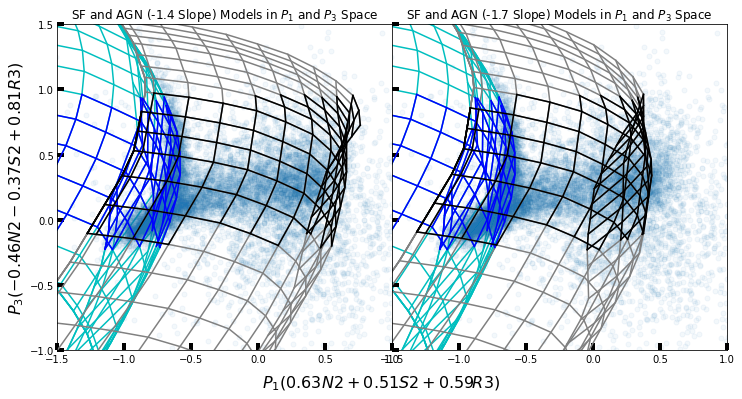

In [30]:
# BPT diagram in P1 and P3 Plane with SF Model and AGN Models
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=10, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=10, width=4., length=7., direction='in')

fig.text(0.5, 0.04, '$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', ha='center', fontsize = 16)
axes[0].set_ylabel('$P_{3}(-0.46N2 - 0.37S2 + 0.81R3)$', fontsize=16)
axes[0].set_title('SF and AGN (-1.4 Slope) Models in $P_{1}$ and $P_{3}$ Space', fontsize= 12)
axes[1].set_title('SF and AGN (-1.7 Slope) Models in $P_{1}$ and $P_{3}$ Space', fontsize= 12)

# Starforming Model
for i in range(new_n2ha.shape[0]): #metallicity
    axes[0].plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i], -0.46*new_n2ha[i] - 0.37*new_s2ha[i] + 0.81*new_o3hb[i], color='c', lw=1.5, zorder = 1)
    axes[1].plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i], -0.46*new_n2ha[i] - 0.37*new_s2ha[i] + 0.81*new_o3hb[i], color='c', lw=1.5, zorder = 1)

for j in range(new_n2ha.shape[1]): #ionization
    axes[0].plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.46*new_n2ha[:,j] - 0.37*new_s2ha[:,j] + 0.81*new_o3hb[:,j], color='c', lw=1.5, zorder = 1)
    axes[1].plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.46*new_n2ha[:,j] - 0.37*new_s2ha[:,j] + 0.81*new_o3hb[:,j], color='c', lw=1.5, zorder = 1)

# AGN (-1.4 Model)
for i in range(new_n2ha_1d4.shape[0]): #metallicity
    axes[0].plot(0.63*new_n2ha_1d4[i] + 0.51*new_s2ha_1d4[i] + 0.59*new_o3hb_1d4[i], -0.46*new_n2ha_1d4[i] - 0.37*new_s2ha_1d4[i] + 0.81*new_o3hb_1d4[i], color='gray', lw=1.5)
    
for j in range(new_n2ha_1d4.shape[1]): #ionization
    axes[0].plot(0.63*new_n2ha_1d4[:,j] + 0.51*new_s2ha_1d4[:,j] + 0.59*new_o3hb_1d4[:,j], -0.46*new_n2ha_1d4[:,j] - 0.37*new_s2ha_1d4[:,j] + 0.81*new_o3hb_1d4[:,j], color='gray', lw=1.5)

# AGN (-1.7 Model)
for i in range(new_n2ha_1d7.shape[0]): #metallicity
    axes[1].plot(0.63*new_n2ha_1d7[i] + 0.51*new_s2ha_1d7[i] + 0.59*new_o3hb_1d7[i], -0.46*new_n2ha_1d7[i] - 0.37*new_s2ha_1d7[i] + 0.81*new_o3hb_1d7[i],  color='gray', lw=1.5)

for j in range(new_n2ha_1d7.shape[1]): #ionization
    axes[1].plot(0.63*new_n2ha_1d7[:,j] + 0.51*new_s2ha_1d7[:,j] + 0.59*new_o3hb_1d7[:,j], -0.46*new_n2ha_1d7[:,j] - 0.37*new_s2ha_1d7[:,j] + 0.81*new_o3hb_1d7[:,j], color='gray', lw=1.5)
    
# Overlay parts of the model that need to be KEPT
for i in range(new_n2ha.shape[0]): #metallicity
    new_keep_SF = keep_SF[i]
    new_P1_SF = P1_SF[i]
    new_P3_SF = P3_SF[i]

    axes[0].plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)
    axes[1].plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)

for j in range(new_n2ha.shape[1]): #ionization
    new_keep_SF = keep_SF[:, j]
    new_P1_SF = P1_SF[:, j]
    new_P3_SF = P3_SF[:, j]

    axes[0].plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5, zorder = 2)
    axes[1].plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5, zorder = 2)
    
# -1.4 AGN MODEL
for i in range(new_n2ha_1d4.shape[0]): #metallicity
    new_keep_AGN1d4 = keep_AGN1d4[i]
    new_P1_AGN1d4 = P1_AGN1d4[i]
    new_P3_AGN1d4 = P3_AGN1d4[i]

    axes[0].plot(new_P1_AGN1d4[new_keep_AGN1d4], new_P3_AGN1d4[new_keep_AGN1d4], color='k', lw=1.5)

for j in range(new_n2ha_1d4.shape[1]): #ionization
    new_keep_AGN1d4 = keep_AGN1d4[:, j]
    new_P1_AGN1d4 = P1_AGN1d4[:, j]
    new_P3_AGN1d4 = P3_AGN1d4[:, j]

    axes[0].plot(new_P1_AGN1d4[new_keep_AGN1d4], new_P3_AGN1d4[new_keep_AGN1d4], color='k', lw=1.5)

# -1.7 AGN MODEL
for i in range(new_n2ha_1d7.shape[0]): #metallicity
    new_keep_AGN1d7 = keep_AGN1d7[i]
    new_P1_AGN1d7 = P1_AGN1d7[i]
    new_P3_AGN1d7 = P3_AGN1d7[i]

    axes[1].plot(new_P1_AGN1d7[new_keep_AGN1d7], new_P3_AGN1d7[new_keep_AGN1d7], color='k', lw=1.5)

for j in range(new_n2ha_1d7.shape[1]): #ionization
    new_keep_AGN1d7 = keep_AGN1d7[:, j]
    new_P1_AGN1d7 = P1_AGN1d7[:, j]
    new_P3_AGN1d7 = P3_AGN1d7[:, j]

    axes[1].plot(new_P1_AGN1d7[new_keep_AGN1d7], new_P3_AGN1d7[new_keep_AGN1d7], color='k', lw=1.5)

# CENTRALFLUX DATA
axes[0].scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.46*centralflux_data['log_NII_Ha_cf'] - 0.37*centralflux_data['log_SII_Ha_cf'] + 0.81*centralflux_data['log_OIII_Hb_cf'], alpha = 0.05, s = 25)
axes[1].scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.46*centralflux_data['log_NII_Ha_cf'] - 0.37*centralflux_data['log_SII_Ha_cf'] + 0.81*centralflux_data['log_OIII_Hb_cf'], alpha = 0.05, s = 25)

axes[0].set_xlim(-1.5, 1.0)
axes[0].set_ylim(-1.0,1.5)
axes[1].set_xlim(-1.5, 1.0)
axes[1].set_ylim(-1.0,1.5)
  
plt.savefig('reproj_p1p3.png')
plt.show()

# Iso-Metallicity Bundles

## debugging

In [31]:
#input flux values from the interpolated model grids!
#initially thought i had to be halpha_SF/halpha_AGN but that's incorrect


def iso_metallicity(n2ha_agn, s2ha_agn, r3hb_agn, n2ha_sf, s2ha_sf, r3hb_sf):
    
    i = 0 #should lie exactly on the AGN model!
    #i = 1e6 #should lie on the SF model!
    j = 1.35*i
    
    #iso metallicity line RATIO
    N2obs_val = np.log10((10**n2ha_agn + i*10**n2ha_sf)/(1 + i))
    S2obs_val = np.log10((10**s2ha_agn + i*10**s2ha_sf)/(1 + i))
    R3obs_val = np.log10((10**r3hb_agn + j*10**r3hb_sf)/(1 + j))
    
    return N2obs_val, S2obs_val, R3obs_val

In [32]:
iso_bundles = iso_metallicity(new_n2ha_1d4, new_s2ha_1d4, new_o3hb_1d4, 
                              new_n2ha, new_s2ha, new_o3hb)

N2obs_val = iso_bundles[0]
S2obs_val = iso_bundles[1]
R3obs_val = iso_bundles[2]

In [33]:
print(N2obs_val[10]) #[metallicity, ionization]

[ 0.20994542  0.22360328  0.23726114  0.25091901  0.26049571  0.25374774
  0.24699977  0.24025181  0.21837629  0.17380946  0.12924262  0.08467579
  0.0336242  -0.02175057 -0.07712534 -0.13250011 -0.17510198 -0.21451062
 -0.25391926 -0.2933279 ]


## Double checking N2/Ha, S2/Ha, and O3/Hb line ratios:

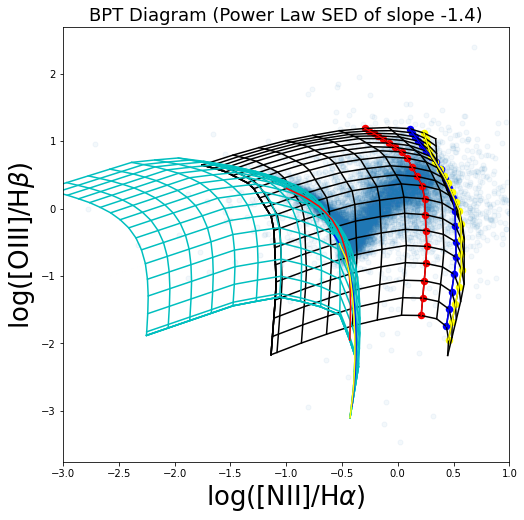

In [34]:
# -1.4 POWER LAW SLOPE AGN MODEL

plt.figure(figsize=(8, 8))
           
plt.xlabel('log([NII]/H$\\alpha$)', fontsize=26)
plt.ylabel('log([OIII]/H$\\beta$)', fontsize=26)
plt.title('BPT Diagram (Power Law SED of slope -1.4)', fontsize= 18)

for i in range(new_n2ha_1d4.shape[0]): #metallicities
    plt.plot(new_n2ha_1d4[i], new_o3hb_1d4[i], color='k', lw=1.5)
      
for j in range(new_n2ha_1d4.shape[1]): #ionization
    plt.plot(new_n2ha_1d4[:,j], new_o3hb_1d4[:,j], color='k', lw=1.5)
    
plt.plot(new_n2ha_1d4[10], new_o3hb_1d4[10], color='r', lw=1.5)
plt.plot(new_n2ha_1d4[12], new_o3hb_1d4[12], color='b', lw=1.5)
plt.plot(new_n2ha_1d4[13], new_o3hb_1d4[13], color='yellow', lw=1.5)

    
# STARFORMING MODEL
for i in range(new_n2ha.shape[0]): #metallicities
    plt.plot(new_n2ha[i], new_o3hb[i], color='c', lw=1.5)

for j in range(new_n2ha.shape[1]): #ionization
    plt.plot(new_n2ha[:,j], new_o3hb[:,j], color='c', lw=1.5)
    
plt.plot(new_n2ha[10], new_o3hb[10], color='r', lw=1.5)
plt.plot(new_n2ha[12], new_o3hb[12], color='b', lw=1.5)
plt.plot(new_n2ha[13], new_o3hb[13], color='yellow', lw=1.5)


# CENTRALFLUX DATA

plt.scatter(centralflux_data['log_NII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
plt.xlim(-3.0,1.0)


''' Let's pick out metallicities close to the ones Ji & Yan used: [O/H] = 0.15, 0.30, 0.45. 
    In our interpolated grids, we get [O/H] = 0.164, 0.31, 0.45 
    --> new_n2ha[:,10], [:,11], [:,12] indices respectively'''

iso_bundles = iso_metallicity(new_n2ha_1d4, new_s2ha_1d4, new_o3hb_1d4, 
                              new_n2ha, new_s2ha, new_o3hb)

N2obs_val = iso_bundles[0]
S2obs_val = iso_bundles[1]
R3obs_val = iso_bundles[2]

for i in range(new_n2ha.shape[1]): # iterate over each ionization
    # iso metallicity bundle for [O/H] = 0.10263158
    plt.scatter(N2obs_val[10][i], R3obs_val[10][i], color='r', lw=1.5)

    # iso metallicity bundle for [O/H] = 0.31842105
    plt.scatter(N2obs_val[12][i], R3obs_val[12][i], color='b', lw=1.5)

    # iso metallicity bundle for [O/H] = 0.53421053
    plt.scatter(N2obs_val[13][i], R3obs_val[13][i], color='yellow', lw=1.5)
    
plt.show()

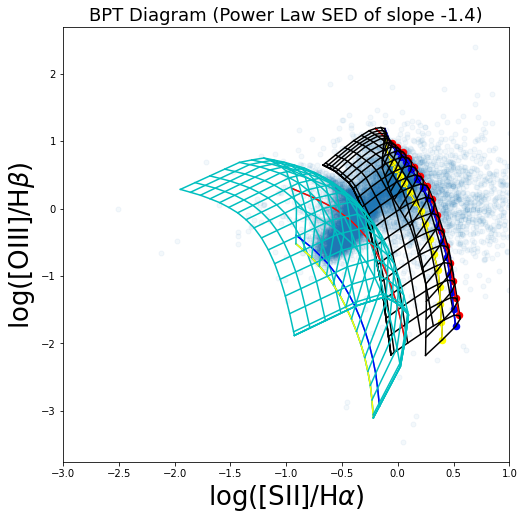

In [35]:
# -1.4 POWER LAW SLOPE AGN MODEL

plt.figure(figsize=(8, 8))
           
plt.xlabel('log([SII]/H$\\alpha$)', fontsize=26)
plt.ylabel('log([OIII]/H$\\beta$)', fontsize=26)
plt.title('BPT Diagram (Power Law SED of slope -1.4)', fontsize= 18)

for i in range(new_s2ha_1d4.shape[0]): #metallicity
    plt.plot(new_s2ha_1d4[i], new_o3hb_1d4[i], color='k', lw=1.5)
      
plt.plot(new_s2ha_1d4[10], new_o3hb_1d4[10], color='r', lw=1.5)
plt.plot(new_s2ha_1d4[12], new_o3hb_1d4[12], color='b', lw=1.5)
plt.plot(new_s2ha_1d4[13], new_o3hb_1d4[13], color='yellow', lw=1.5)

for j in range(new_s2ha_1d4.shape[1]): #ionization
    plt.plot(new_s2ha_1d4[:,j], new_o3hb_1d4[:,j], color='k', lw=1.5)

    
# STARFORMING MODEL
for i in range(new_s2ha.shape[0]): #metallicity
    plt.plot(new_s2ha[i], new_o3hb[i], color='c', lw=1.5)

plt.plot(new_s2ha[10], new_o3hb[10], color='r', lw=1.5)
plt.plot(new_s2ha[12], new_o3hb[12], color='b', lw=1.5)
plt.plot(new_s2ha[13], new_o3hb[13], color='yellow', lw=1.5)

for j in range(new_s2ha.shape[1]): #ionization
    plt.plot(new_s2ha[:,j], new_o3hb[:,j], color='c', lw=1.5)


# CENTRALFLUX DATA
plt.scatter(centralflux_data['log_SII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
plt.xlim(-3.0,1.0)

iso_bundles = iso_metallicity(new_n2ha_1d4, new_s2ha_1d4, new_o3hb_1d4, 
                              new_n2ha, new_s2ha, new_o3hb)

N2obs_val = iso_bundles[0]
S2obs_val = iso_bundles[1]
R3obs_val = iso_bundles[2]
#print(R3_obs)
#print(R3_obs[0][13])

for i in range(new_s2ha.shape[0]): # iterate over each ionization
    # iso metallicity bundle for [O/H] = 0.164 
    plt.scatter(S2obs_val[10][i], R3obs_val[10][i], color='r', lw=1.5)

    # iso metallicity bundle for [O/H] = 0.31
    plt.scatter(S2obs_val[12][i], R3obs_val[12][i], color='b', lw=1.5)

    # iso metallicity bundle for [O/H] = 0.45
    plt.scatter(S2obs_val[13][i], R3obs_val[13][i], color='yellow', lw=1.5)
    
plt.show()

## P1 and P2 Plane

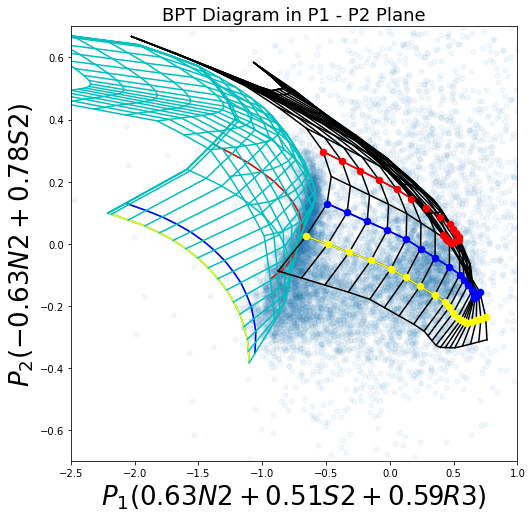

In [36]:
plt.figure(figsize=(8, 8))

# Starforming Model
for i in range(new_n2ha.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i],-0.63*new_n2ha[i] + 0.78*new_s2ha[i], color='c', lw=1.5)

#to check ratios of the specific metallicity values im interested in
plt.plot(0.63*new_n2ha[10] + 0.51*new_s2ha[10] + 0.59*new_o3hb[10], -0.63*new_n2ha[10] + 0.78*new_s2ha[10], color='r', lw=1.5)
plt.plot(0.63*new_n2ha[12] + 0.51*new_s2ha[12] + 0.59*new_o3hb[12], -0.63*new_n2ha[12] + 0.78*new_s2ha[12], color='b', lw=1.5)
plt.plot(0.63*new_n2ha[13] + 0.51*new_s2ha[13] + 0.59*new_o3hb[13], -0.63*new_n2ha[13] + 0.78*new_s2ha[13], color='yellow', lw=1.5)

for j in range(new_n2ha.shape[1]): #ionization
    plt.plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.63*new_n2ha[:,j] + 0.78*new_s2ha[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for m in range(new_n2ha_1d4.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha_1d4[m] + 0.51*new_s2ha_1d4[m] + 0.59*new_o3hb_1d4[m],-0.63*new_n2ha_1d4[m] + 0.78*new_s2ha_1d4[m], color='k', lw=1.5)

#to check ratios of the specific [O/H] values im interested in
plt.plot(0.63*new_n2ha_1d4[10] + 0.51*new_s2ha_1d4[10] + 0.59*new_o3hb_1d4[10], -0.63*new_n2ha_1d4[10] + 0.78*new_s2ha_1d4[10], color='r', lw=1.5)
plt.plot(0.63*new_n2ha_1d4[12] + 0.51*new_s2ha_1d4[12] + 0.59*new_o3hb_1d4[12], -0.63*new_n2ha_1d4[12] + 0.78*new_s2ha_1d4[12], color='b', lw=1.5)
plt.plot(0.63*new_n2ha_1d4[13] + 0.51*new_s2ha_1d4[13] + 0.59*new_o3hb_1d4[13], -0.63*new_n2ha_1d4[13] + 0.78*new_s2ha_1d4[13], color='yellow', lw=1.5)

for n in range(new_n2ha_1d4.shape[1]):#ionization
    plt.plot(0.63*new_n2ha_1d4[:,n] + 0.51*new_s2ha_1d4[:,n] + 0.59*new_o3hb_1d4[:,n], -0.63*new_n2ha_1d4[:,n] + 0.78*new_s2ha_1d4[:,n], color='k', lw=1.5)
    
iso_bundles = iso_metallicity(new_n2ha_1d4, new_s2ha_1d4, new_o3hb_1d4, 
                              new_n2ha, new_s2ha, new_o3hb)

N2obs_val = iso_bundles[0]
S2obs_val = iso_bundles[1]
R3obs_val = iso_bundles[2]

P1_metal_1 = np.zeros(new_n2ha.shape[1])
P1_metal_2 = np.zeros(new_n2ha.shape[1])
P1_metal_3 = np.zeros(new_n2ha.shape[1])

P2_metal_1 = np.zeros(new_n2ha.shape[1])
P2_metal_2 = np.zeros(new_n2ha.shape[1])
P2_metal_3 = np.zeros(new_n2ha.shape[1])  

# iso metallicity bundle for [O/H] = 0.164
for i in range(new_n2ha.shape[1]): # iterate over each ionization for [O/H] = 0.10263158
    P1_metal_1[i] = 0.63*N2obs_val[10][i] + 0.51*S2obs_val[10][i] + 0.59*R3obs_val[10][i]
    P2_metal_1[i] = -0.63*N2obs_val[10][i] + 0.78*S2obs_val[10][i]

    plt.scatter(P1_metal_1[i], P2_metal_1[i], color='r', lw=1.5, zorder = 2)

z = np.polyfit(P1_metal_1, P2_metal_1, 1)
p = np.poly1d(z)

#plt.plot(P1_metal_1, p(P1_metal_1), 'r--', lw = 1.5, label = '[O/H] = 0.10')

# iso metallicity bundle for [O/H] = 0.31
for i in range(new_n2ha.shape[1]): # iterate over each ionization
    P1_metal_2[i] = 0.63*N2obs_val[12][i] + 0.51*S2obs_val[12][i] + 0.59*R3obs_val[12][i]
    P2_metal_2[i] = -0.63*N2obs_val[12][i] + 0.78*S2obs_val[12][i]

    plt.scatter(P1_metal_2[i], P2_metal_2[i], color='b', lw=1.5, zorder = 2)

z = np.polyfit(P1_metal_2, P2_metal_2, 1)
p = np.poly1d(z)

#plt.plot(P1_metal_1, p(P1_metal_1), 'b--', lw = 1.5, label = '[O/H] = 0.32')

# iso metallicity bundle for [O/H] = 0.45
for i in range(new_n2ha.shape[1]): # iterate over each ionization
    P1_metal_3[i] = 0.63*N2obs_val[13][i] + 0.51*S2obs_val[13][i] + 0.59*R3obs_val[13][i]
    P2_metal_3[i] = -0.63*N2obs_val[13][i] + 0.78*S2obs_val[13][i]

    plt.scatter(P1_metal_3[i], P2_metal_3[i], color='yellow', lw=1.5, zorder = 2)

z = np.polyfit(P1_metal_3, P2_metal_3, 1)
p = np.poly1d(z)

#plt.plot(P1_metal_3, p(P1_metal_3), 'yellow', linestyle = '--', lw = 1.5, label = '[O/H] = 0.53')

# CENTRALFLUX DATA

plt.scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25)
plt.xlim(-2.5,1.0)
plt.ylim(-0.7,0.7)
plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=26)
plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=26)
plt.title('BPT Diagram in P1 - P2 Plane', fontsize= 18)
#plt.legend()
plt.show()

# March 23, 2023

- have iso_metallicity func. take in i
- goal is to dial in on the value for i
- loop over all i's (range from 0 - maybe 100 or 500)
- iso_metallicity will return a grid in between the SF and AGN models
- if we are interested in a particular metallicity and ionization --> find that row/column in the i direction

In [37]:
#input flux values from the interpolated model grids!

def iso_metallicity(n2ha_agn, s2ha_agn, r3hb_agn, n2ha_sf, s2ha_sf, r3hb_sf, i):
    j = 1.35*i

    #iso metallicity line RATIO
    N2obs_val = np.log10((10**n2ha_agn + i*10**n2ha_sf)/(1 + i))
    S2obs_val = np.log10((10**s2ha_agn + i*10**s2ha_sf)/(1 + i))
    R3obs_val = np.log10((10**r3hb_agn + j*10**r3hb_sf)/(1 + j))

    return N2obs_val, S2obs_val, R3obs_val

In [38]:
#check to make sure at i = 0, the grid lies exactly on the AGN model

iso_bundles = iso_metallicity(new_n2ha_1d4, new_s2ha_1d4, new_o3hb_1d4, 
                new_n2ha, new_s2ha, new_o3hb, 0)

N2obs_val = iso_bundles[0]
S2obs_val = iso_bundles[1]
R3obs_val = iso_bundles[2]

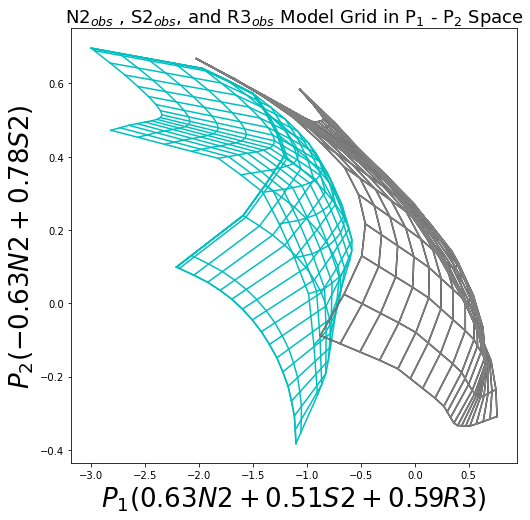

In [39]:
plt.figure(figsize=(8, 8))
           
plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=26)
plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=26)
plt.title(r'N2$_{obs}$ , S2$_{obs}$, and R3$_{obs}$ Model Grid in P$_1$ - P$_2$ Space', fontsize= 18)

# Starforming Model
for i in range(new_n2ha.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i],-0.63*new_n2ha[i] + 0.78*new_s2ha[i], color='c', lw=1.5)

for j in range(new_n2ha.shape[1]): #ionization
    plt.plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.63*new_n2ha[:,j] + 0.78*new_s2ha[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for m in range(new_n2ha_1d4.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha_1d4[m] + 0.51*new_s2ha_1d4[m] + 0.59*new_o3hb_1d4[m],-0.63*new_n2ha_1d4[m] + 0.78*new_s2ha_1d4[m], color='k', lw=1.5)

for n in range(new_n2ha_1d4.shape[1]):#ionization
    plt.plot(0.63*new_n2ha_1d4[:,n] + 0.51*new_s2ha_1d4[:,n] + 0.59*new_o3hb_1d4[:,n], -0.63*new_n2ha_1d4[:,n] + 0.78*new_s2ha_1d4[:,n], color='k', lw=1.5)

#N2 OBS and R3 OBS
for i in range(N2obs_val.shape[0]): #metallicities
    plt.plot(0.63*N2obs_val[i] + 0.51*S2obs_val[i] + 0.59*R3obs_val[i], -0.63*N2obs_val[i] + 0.78*S2obs_val[i], color='gray', lw=1.5)
      
for j in range(N2obs_val.shape[1]): #ionization
    plt.plot(0.63*N2obs_val[:,j] + 0.51*S2obs_val[:,j] + 0.59*R3obs_val[:,j], -0.63*N2obs_val[:,j] + 0.78*S2obs_val[:,j], color='gray', lw=1.5)


## Loop over i

- decided to make individual functions for N2, S2, and R3


- cut grids according to data that lies within P3
- for each metallicity, look at the i range thats included
- step thru each metallicty
- determine which ionization to use in each grid
- then make a line between each of those

In [40]:
N2obs_data = []
S2obs_data = []
R3obs_data = []

In [41]:
# input flux values from the interpolated model grids!

def N2_obs(n2ha_agn, n2ha_sf, i):
    N2_obs = np.log10((10**n2ha_agn + i*10**n2ha_sf)/(1 + i))

    return N2_obs

def S2_obs(s2ha_agn, s2ha_sf, i):
    S2_obs = np.log10((10**s2ha_agn + i*10**s2ha_sf)/(1 + i))

    return S2_obs

def R3_obs(r3hb_agn, r3hb_sf, i):
    j = 1.35*i

    R3_obs = np.log10((10**r3hb_agn + j*10**r3hb_sf)/(1 + j))

    return R3_obs

In [42]:
for num in np.linspace(0,500):
    N2obs_data.append(N2_obs(new_n2ha_1d4, new_n2ha, num))
    S2obs_data.append(S2_obs(new_s2ha_1d4, new_s2ha, num))
    R3obs_data.append(R3_obs(new_o3hb_1d4, new_o3hb, num))
    
N2obs_arr = np.asarray(N2obs_data)
S2obs_arr = np.asarray(S2obs_data)
R3obs_arr = np.asarray(R3obs_data)

In [43]:
P1_obs = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1],N2obs_arr.shape[2]))
P2_obs = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1], N2obs_arr.shape[2]))
P3_obs = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1], N2obs_arr.shape[2]))

In [44]:
def reprojected_obs(N2_obs, S2_obs, R3_obs, i_shape, metallicity_shape, ionization_shape):
    """Function to make arrays of the observed N2, S2, R3 models in P space"""

    for i in range(i_shape): 
        for j in range(metallicity_shape): #metallicity grid
            for k in range(ionization_shape): #ionization grid
                P1_obs[i,j,k] = 0.63*N2_obs[i,j,k] + 0.51*S2_obs[i,j,k] + 0.59*R3_obs[i,j,k]
                P2_obs[i,j,k] = -0.63*N2_obs[i,j,k] + 0.78*S2_obs[i,j,k]
                P3_obs[i,j,k] = -0.46*N2_obs[i,j,k] - 0.37*S2_obs[i,j,k] + 0.81*R3_obs[i,j,k]

    return

In [45]:
# Extracting indices to keep based on our P3 limits
metal_P1obs = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1],N2obs_arr.shape[2]))
metal_P2obs = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1], N2obs_arr.shape[2]))
metal_keepobs_arr = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1], N2obs_arr.shape[2]))

ion_P1obs = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1],N2obs_arr.shape[2]))
ion_P2obs = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1], N2obs_arr.shape[2]))
ion_keepobs_arr = np.zeros((N2obs_arr.shape[0], N2obs_arr.shape[1], N2obs_arr.shape[2]))

def obs_p1p2_cut(P1_SF, P2_SF, keep_SF, P1_AGN, P2_AGN, keep_AGN, SF_metallicity_shape, SF_ionization_shape, AGN_metallicity_shape, AGN_ionization_shape, P1_obs, P2_obs, i_shape, metallicity_shape, ionization_shape):
    """ Function takes in P1_SF, P2_SF, keep_SF, P1_AGN1d4, P2_AGN1d4, keep_AGN1d4, SF_metallicity_shape, 
        SF_ionization_shape, AGN_metallicity_shape, AGN_ionization_shape, P1_obs, P2_obs, i_shape, 
        metallicity_shape, and ionization_shape"""

    plt.figure(figsize=(9, 9))
    
    for i in range(SF_ionization_shape): #iterate over all ionizations
        ion_keep_SF = keep_SF[:, i]
        ion_P1_SF = P1_SF[:, i]
        ion_P2_SF = P2_SF[:, i]

        plt.plot(ion_P1_SF[ion_keep_SF], ion_P2_SF[ion_keep_SF], color='c', lw=1.5, zorder = 2)

    for j in range(SF_metallicity_shape): #iterate over all metallicities
        
        metal_keep_SF = keep_SF[j]
        metal_P1_SF = P1_SF[j]
        metal_P2_SF = P2_SF[j]
        
        #print(metal_keep_SF.shape) --> 20
        
        plt.plot(metal_P1_SF[metal_keep_SF], metal_P2_SF[metal_keep_SF], color='c', lw=1.5, zorder = 2)

    for m in range(AGN_ionization_shape):
        ion_keep_AGN = keep_AGN[:, m]
        ion_P1_AGN = P1_AGN[:, m]
        ion_P2_AGN = P2_AGN[:, m]

        plt.plot(ion_P1_AGN[ion_keep_AGN], ion_P2_AGN[ion_keep_AGN], color='k', lw=1.5)

    for n in range(AGN_metallicity_shape):
        metal_keep_AGN = keep_AGN[n]
        metal_P1_AGN = P1_AGN[n]
        metal_P2_AGN = P2_AGN[n]
        
        plt.plot(metal_P1_AGN[metal_keep_AGN], metal_P2_AGN[metal_keep_AGN], color='k', lw=1.5)

    #isometallicity bundle grid
    keep_obs = ((P3_obs > -0.23) & (P3_obs < 0.98))
    
    for i in range(N2obs_arr.shape[0]):
        for j in range(N2obs_arr.shape[1]):#metallicity
            metal_keepobs = keep_obs[i,j]
            metal_keepobs_arr[i,j] = keep_obs[i,j]
            
            metal_P1obs[i,j] = P1_obs[i,j]
            metal_P2obs[i,j] = P2_obs[i,j]
            
            plt.plot(metal_P1obs[i,j][metal_keepobs], metal_P2obs[i,j][metal_keepobs], color='grey', lw=1.5, zorder=1)

    for i in range(N2obs_arr.shape[0]):
        for k in range(N2obs_arr.shape[2]): #ionization
            ion_keepobs = keep_obs[i,:,k]
            ion_keepobs_arr[i,:,k] = keep_obs[i,:,k]

            ion_P1obs[i,:,k] = P1_obs[i,:,k]
            ion_P2obs[i,:,k] = P2_obs[i,:,k]

            plt.plot(ion_P1obs[i,:,k][ion_keepobs], ion_P2obs[i,:,k][ion_keepobs], color='grey', lw=1.5, zorder = 1)
    
    
    plt.scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25, label = 'Data')

    plt.title('BPT Diagram with Iso-Metallicity Bundle Grids', fontsize= 14)
    plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=18)
    plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=18)
    plt.xlim(-2.5,1.0)
    plt.ylim(-0.7,0.7)
    plt.legend()
    plt.show()
    
    return

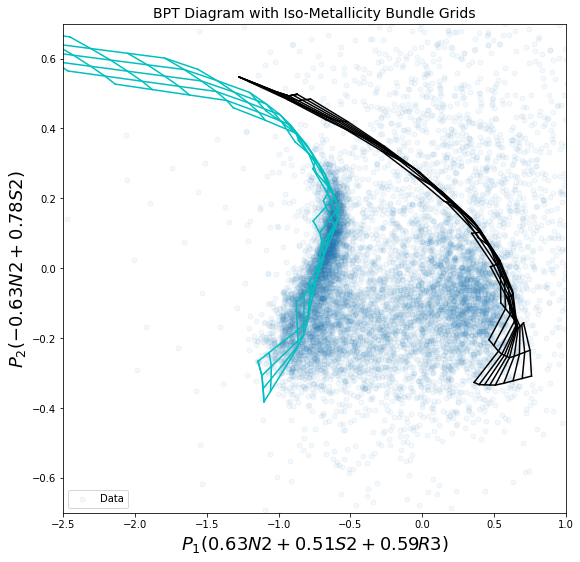

In [46]:
""" Function takes in P1_SF, P2_SF, keep_SF, P1_AGN1d4, P2_AGN1d4, keep_AGN1d4, SF_metallicity_shape, 
    SF_ionization_shape, AGN_metallicity_shape, AGN_ionization_shape, P1_obs, P2_obs, i_shape, 
    metallicity_shape, and ionization_shape"""
    
results = obs_p1p2_cut(P1_SF, P2_SF, keep_SF, P1_AGN1d4, P2_AGN1d4, keep_AGN1d4, new_n2ha.shape[0],
             new_n2ha.shape[1], new_n2ha_1d4.shape[0], new_n2ha_1d4.shape[1],
             P1_obs, P2_obs, N2obs_arr.shape[0], N2obs_arr.shape[1], N2obs_arr.shape[2])

## APRIL 13, 2023
Goals: 
- determine which ionization to use in each grey grid
- then make a line between each of those

In [47]:
''' Now pick out metallicities close to the ones Ji & Yan used: [O/H] = 0.15, 0.30, 0.45. 
    In our interpolated grids, we get [O/H] = 0.16428571, 0.31071429, 0.45714286. 
    The indices are [:,10], [:,11], and [:,12] respectively.
    - The arrays below includes all N2, S2, R3 obs calculations at metallicity 
    [O/H] = 0.16428571 for each i in np.linspace(0,500)'''

N2obs_arr[:,10].shape
S2obs_arr[:,10].shape
R3obs_arr[:,10].shape

(50, 20)

In [48]:
N2obs_arr[:,10][:,0] # 0th ionization parameter for the 10th metallicity

array([ 0.20994542, -0.31613854, -0.36681982, -0.38630304, -0.39662646,
       -0.40302191, -0.40737334, -0.41052578, -0.41291485, -0.4147879 ,
       -0.41629584, -0.41753594, -0.41857376, -0.41945505, -0.42021274,
       -0.42087114, -0.42144856, -0.42195907, -0.42241368, -0.42282108,
       -0.42318826, -0.42352091, -0.42382367, -0.4241004 , -0.42435432,
       -0.42458814, -0.42480415, -0.42500431, -0.42519031, -0.42536359,
       -0.42552542, -0.4256769 , -0.42581899, -0.42595254, -0.42607829,
       -0.4261969 , -0.42630898, -0.42641504, -0.42651556, -0.42661095,
       -0.42670161, -0.42678787, -0.42687005, -0.42694843, -0.42702327,
       -0.42709481, -0.42716325, -0.42722879, -0.42729162, -0.4273519 ])

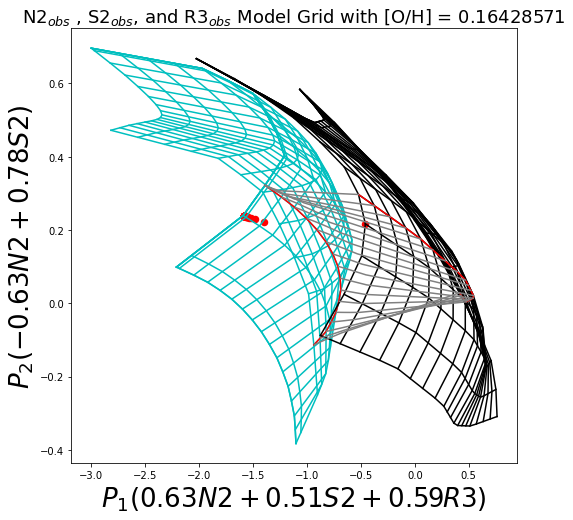

In [49]:
plt.figure(figsize=(8, 8))
           
plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=26)
plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=26)
plt.title(r'N2$_{obs}$ , S2$_{obs}$, and R3$_{obs}$ Model Grid with [O/H] = 0.16428571', fontsize= 18)

# Starforming Model
for i in range(new_n2ha.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i],-0.63*new_n2ha[i] + 0.78*new_s2ha[i], color='c', lw=1.5)

for j in range(new_n2ha.shape[1]): #ionization
    plt.plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.63*new_n2ha[:,j] + 0.78*new_s2ha[:,j], color='c', lw=1.5)

#to check ratios of the specific metallicity values im interested in
plt.plot(0.63*new_n2ha[10] + 0.51*new_s2ha[10] + 0.59*new_o3hb[10], -0.63*new_n2ha[10] + 0.78*new_s2ha[10], color='r', lw=1.5)

# AGN (-1.4 Model)
for m in range(new_n2ha_1d4.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha_1d4[m] + 0.51*new_s2ha_1d4[m] + 0.59*new_o3hb_1d4[m],-0.63*new_n2ha_1d4[m] + 0.78*new_s2ha_1d4[m], color='k', lw=1.5)

for n in range(new_n2ha_1d4.shape[1]):#ionization
    plt.plot(0.63*new_n2ha_1d4[:,n] + 0.51*new_s2ha_1d4[:,n] + 0.59*new_o3hb_1d4[:,n], -0.63*new_n2ha_1d4[:,n] + 0.78*new_s2ha_1d4[:,n], color='k', lw=1.5)

#to check ratios of the specific [O/H] values im interested in
plt.plot(0.63*new_n2ha_1d4[10] + 0.51*new_s2ha_1d4[10] + 0.59*new_o3hb_1d4[10], -0.63*new_n2ha_1d4[10] + 0.78*new_s2ha_1d4[10], color='r', lw=1.5)

# N2_obs, S2_obs, and R3_obs in P1 - P2 space
for j in range(N2obs_arr.shape[2]): #iterate over all ionization parameters
    plt.plot(0.63*N2obs_arr[:,10][:,j] + 0.51*S2obs_arr[:,10][:,j] + 0.59*R3obs_arr[:,10][:,j], -0.63*N2obs_arr[:,10][:,j] + 0.78*S2obs_arr[:,10][:,j], color='gray', lw=1.5)
    #plt.plot(0.63*N2obs_arr[:,10][:,j] + 0.51*S2obs_arr[:,10][:,j] + 0.59*R3obs_arr[:,10][:,j], -0.63*N2obs_arr[:,10][:,j] + 0.78*S2obs_arr[:,10][:,j], color='gray', lw=0.9)

plt.scatter(0.63*N2obs_arr[:,11][:,0] + 0.51*S2obs_arr[:,11][:,0] + 0.59*R3obs_arr[:,11][:,0], -0.63*N2obs_arr[:,11][:,0] + 0.78*S2obs_arr[:,11][:,0], color='red', lw=1.5)


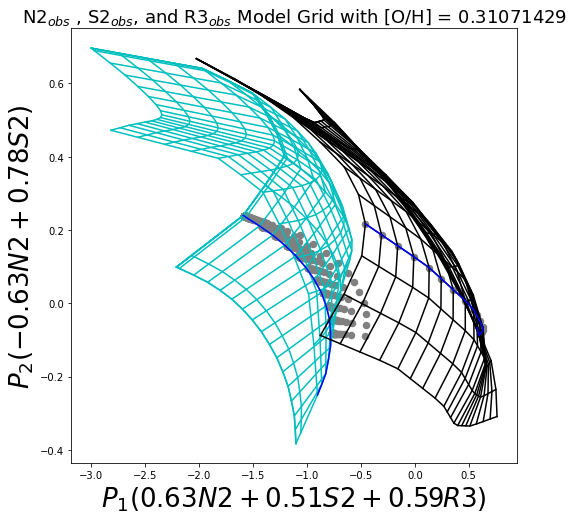

In [50]:
plt.figure(figsize=(8, 8))
           
plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=26)
plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=26)
plt.title(r'N2$_{obs}$ , S2$_{obs}$, and R3$_{obs}$ Model Grid with [O/H] = 0.31071429', fontsize= 18)

# Starforming Model
for i in range(new_n2ha.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i],-0.63*new_n2ha[i] + 0.78*new_s2ha[i], color='c', lw=1.5)

for j in range(new_n2ha.shape[1]): #ionization
    plt.plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.63*new_n2ha[:,j] + 0.78*new_s2ha[:,j], color='c', lw=1.5)

#to check ratios of the specific metallicity values im interested in
plt.plot(0.63*new_n2ha[11] + 0.51*new_s2ha[11] + 0.59*new_o3hb[11], -0.63*new_n2ha[11] + 0.78*new_s2ha[11], color='blue', lw=1.5)

# AGN (-1.4 Model)
for m in range(new_n2ha_1d4.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha_1d4[m] + 0.51*new_s2ha_1d4[m] + 0.59*new_o3hb_1d4[m],-0.63*new_n2ha_1d4[m] + 0.78*new_s2ha_1d4[m], color='k', lw=1.5)

for n in range(new_n2ha_1d4.shape[1]):#ionization
    plt.plot(0.63*new_n2ha_1d4[:,n] + 0.51*new_s2ha_1d4[:,n] + 0.59*new_o3hb_1d4[:,n], -0.63*new_n2ha_1d4[:,n] + 0.78*new_s2ha_1d4[:,n], color='k', lw=1.5)

#to check ratios of the specific [O/H] values im interested in
plt.plot(0.63*new_n2ha_1d4[11] + 0.51*new_s2ha_1d4[11] + 0.59*new_o3hb_1d4[11], -0.63*new_n2ha_1d4[11] + 0.78*new_s2ha_1d4[11], color='blue', lw=1.5)

# N2_obs, S2_obs, and R3_obs in P1 - P2 space
for j in range(N2obs_arr.shape[1]):
    #plt.scatter(0.63*N2obs_arr[:,11][:,j] + 0.51*S2obs_arr[:,11][:,j] + 0.59*R3obs_arr[:,11][:,j], -0.63*N2obs_arr[:,11][:,j] + 0.78*S2obs_arr[:,11][:,j], color='gray', lw=1.5)
    plt.scatter(0.63*N2obs_arr[:,11][:,j] + 0.51*S2obs_arr[:,11][:,j] + 0.59*R3obs_arr[:,11][:,j], -0.63*N2obs_arr[:,11][:,j] + 0.78*S2obs_arr[:,11][:,j], color='gray', lw=1.5)

#plt.plot(0.63*N2obs_arr[:,11][:,0] + 0.51*S2obs_arr[:,11][:,0] + 0.59*R3obs_arr[:,11][:,0], -0.63*N2obs_arr[:,11][:,0] + 0.78*S2obs_arr[:,11][:,0], color='red', lw=1.5)


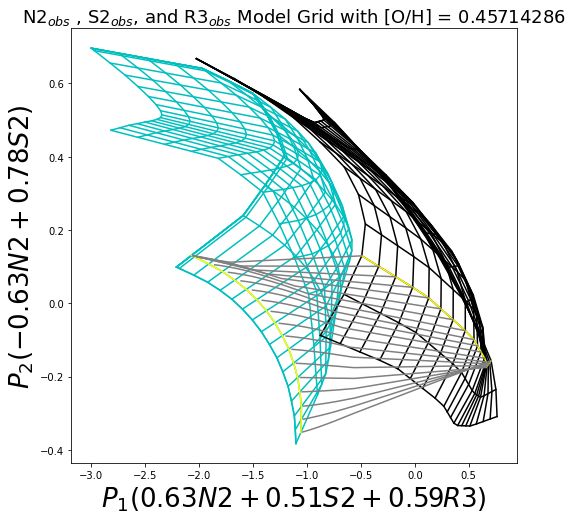

In [51]:
plt.figure(figsize=(8, 8))
           
plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=26)
plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=26)
plt.title(r'N2$_{obs}$ , S2$_{obs}$, and R3$_{obs}$ Model Grid with [O/H] = 0.45714286', fontsize= 18)

# Starforming Model
for i in range(new_n2ha.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha[i] + 0.51*new_s2ha[i] + 0.59*new_o3hb[i],-0.63*new_n2ha[i] + 0.78*new_s2ha[i], color='c', lw=1.5)

for j in range(new_n2ha.shape[1]): #ionization
    plt.plot(0.63*new_n2ha[:,j] + 0.51*new_s2ha[:,j] + 0.59*new_o3hb[:,j], -0.63*new_n2ha[:,j] + 0.78*new_s2ha[:,j], color='c', lw=1.5)

#to check ratios of the specific metallicity values im interested in
plt.plot(0.63*new_n2ha[12] + 0.51*new_s2ha[12] + 0.59*new_o3hb[12], -0.63*new_n2ha[12] + 0.78*new_s2ha[12], color='yellow', lw=1.5)

# AGN (-1.4 Model)
for m in range(new_n2ha_1d4.shape[0]): #metallicity
    plt.plot(0.63*new_n2ha_1d4[m] + 0.51*new_s2ha_1d4[m] + 0.59*new_o3hb_1d4[m],-0.63*new_n2ha_1d4[m] + 0.78*new_s2ha_1d4[m], color='k', lw=1.5)

for n in range(new_n2ha_1d4.shape[1]):#ionization
    plt.plot(0.63*new_n2ha_1d4[:,n] + 0.51*new_s2ha_1d4[:,n] + 0.59*new_o3hb_1d4[:,n], -0.63*new_n2ha_1d4[:,n] + 0.78*new_s2ha_1d4[:,n], color='k', lw=1.5)

#to check ratios of the specific [O/H] values im interested in
plt.plot(0.63*new_n2ha_1d4[12] + 0.51*new_s2ha_1d4[12] + 0.59*new_o3hb_1d4[12], -0.63*new_n2ha_1d4[12] + 0.78*new_s2ha_1d4[12], color='yellow', lw=1.5)

# N2_obs, S2_obs, and R3_obs in P1 - P2 space
for j in range(N2obs_arr.shape[2]):
    plt.plot(0.63*N2obs_arr[:,12][:,j] + 0.51*S2obs_arr[:,12][:,j] + 0.59*R3obs_arr[:,12][:,j], -0.63*N2obs_arr[:,12][:,j] + 0.78*S2obs_arr[:,12][:,j], color='gray', lw=1.5)


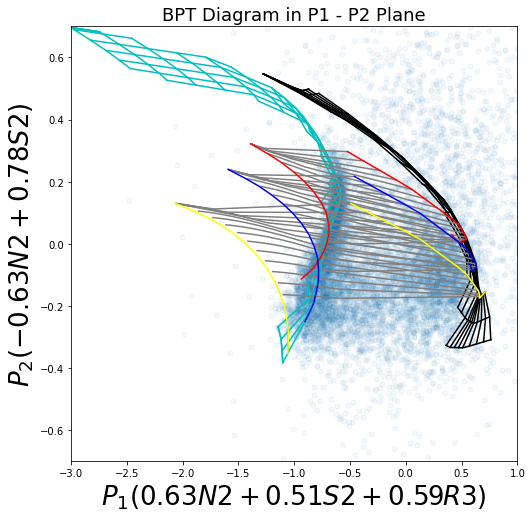

In [52]:
plt.figure(figsize=(8, 8))

#to check ratios of the specific [O/H] values im interested in
plt.plot(0.63*new_n2ha[10] + 0.51*new_s2ha[10] + 0.59*new_o3hb[10], -0.63*new_n2ha[10] + 0.78*new_s2ha[10], color='r', lw=1.5, zorder = 5)
plt.plot(0.63*new_n2ha[11] + 0.51*new_s2ha[11] + 0.59*new_o3hb[11], -0.63*new_n2ha[11] + 0.78*new_s2ha[11], color='b', lw=1.5, zorder = 5)
plt.plot(0.63*new_n2ha[12] + 0.51*new_s2ha[12] + 0.59*new_o3hb[12], -0.63*new_n2ha[12] + 0.78*new_s2ha[12], color='yellow', lw=1.5, zorder = 5)

#to check ratios of the specific [O/H] values im interested in
plt.plot(0.63*new_n2ha_1d4[10] + 0.51*new_s2ha_1d4[10] + 0.59*new_o3hb_1d4[10], -0.63*new_n2ha_1d4[10] + 0.78*new_s2ha_1d4[10], color='r', lw=1.5, zorder = 5)
plt.plot(0.63*new_n2ha_1d4[11] + 0.51*new_s2ha_1d4[11] + 0.59*new_o3hb_1d4[11], -0.63*new_n2ha_1d4[11] + 0.78*new_s2ha_1d4[11], color='b', lw=1.5, zorder = 5)
plt.plot(0.63*new_n2ha_1d4[12] + 0.51*new_s2ha_1d4[12] + 0.59*new_o3hb_1d4[12], -0.63*new_n2ha_1d4[12] + 0.78*new_s2ha_1d4[12], color='yellow', lw=1.5, zorder = 5)

for i in range(new_n2ha.shape[0]): #metallicity

    new_keep_SF = keep_SF[i]
    new_P1_SF = P1_SF[i]
    new_P2_SF = P2_SF[i]

    plt.plot(new_P1_SF[new_keep_SF], new_P2_SF[new_keep_SF], color='c', lw=1.5)
    
for j in range(new_n2ha.shape[1]): #ionization
    new_keep_SF = keep_SF[:, j]
    new_P1_SF = P1_SF[:, j]
    new_P2_SF = P2_SF[:, j]

    plt.plot(new_P1_SF[new_keep_SF], new_P2_SF[new_keep_SF], color='c', lw=1.5)
    
for m in range(new_n2ha.shape[0]): #metallicity
    new_keep_AGN1d4 = keep_AGN1d4[m]
    new_P1_AGN1d4 = P1_AGN1d4[m]
    new_P2_AGN1d4 = P2_AGN1d4[m]

    plt.plot(new_P1_AGN1d4[new_keep_AGN1d4], new_P2_AGN1d4[new_keep_AGN1d4], color='k', lw=1.5)

for n in range(new_n2ha.shape[1]): #ionization
    new_keep_AGN1d4 = keep_AGN1d4[:, n]
    new_P1_AGN1d4 = P1_AGN1d4[:, n]
    new_P2_AGN1d4 = P2_AGN1d4[:, n]

    plt.plot(new_P1_AGN1d4[new_keep_AGN1d4], new_P2_AGN1d4[new_keep_AGN1d4], color='k', lw=1.5)
    

# N2_obs, S2_obs, and R3_obs in P1 - P2 space
for j in range(N2obs_arr.shape[1]):
    plt.plot(0.63*N2obs_arr[:,10][:,j] + 0.51*S2obs_arr[:,10][:,j] + 0.59*R3obs_arr[:,10][:,j], -0.63*N2obs_arr[:,10][:,j] + 0.78*S2obs_arr[:,10][:,j], color='gray', lw=1.5)
    plt.plot(0.63*N2obs_arr[:,11][:,j] + 0.51*S2obs_arr[:,11][:,j] + 0.59*R3obs_arr[:,11][:,j], -0.63*N2obs_arr[:,11][:,j] + 0.78*S2obs_arr[:,11][:,j], color='gray', lw=1.5)
    plt.plot(0.63*N2obs_arr[:,12][:,j] + 0.51*S2obs_arr[:,12][:,j] + 0.59*R3obs_arr[:,12][:,j], -0.63*N2obs_arr[:,12][:,j] + 0.78*S2obs_arr[:,12][:,j], color='gray', lw=1.5)

    
# CENTRALFLUX DATA
plt.scatter(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25)
plt.xlim(-3.0,1.0)
plt.ylim(-0.7,0.7)
plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=26)
plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=26)
plt.title('BPT Diagram in P1 - P2 Plane', fontsize= 18)
#plt.legend()
plt.show()

## Error Propagation

In [53]:
# initialize Pipe3D data
filename = 'SDSS17Pipe3D_v3_1_1.fits'
hdul = fits.open(filename)
pipe3D_galproperties = hdul[1].data

# extract plateifu for each galaxy
MNSA_plateifu = centralflux_data['plateifu']

# match the plateifus from Pipe3D with MNSA
pipe3D_plateifu = pipe3D_galproperties['plateifu'][:]
pipe3D_index = np.zeros(len(pipe3D_plateifu), dtype = int)

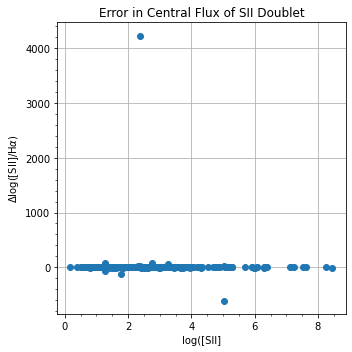

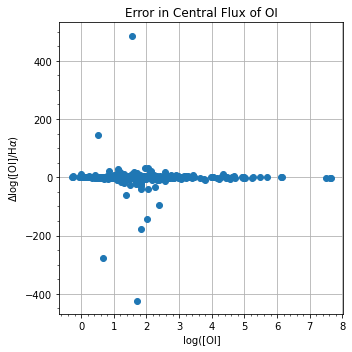

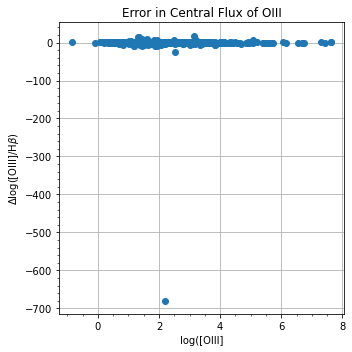

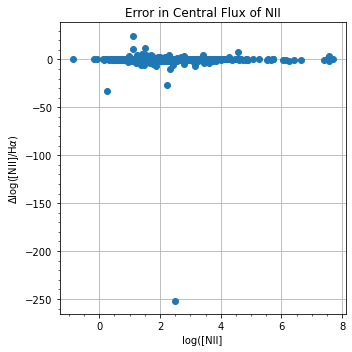

In [54]:
# Now let's check our central flux values with those calculated from Pipe3D

# galaxy properties we are interested in
pipe3D_log_SII_Ha_cf = pipe3D_galproperties['log_SII_Ha_cen'][:]
pipe3D_log_OI_Ha_cf = pipe3D_galproperties['log_OI_Ha_cen'][:]
pipe3D_log_OIII_Hb_cf  = pipe3D_galproperties['log_OIII_Hb_cen'][:]
pipe3D_log_NII_Ha_cf = pipe3D_galproperties['log_NII_Ha_cen'][:]

pipe3D_log_SII_Ha_cf_err = pipe3D_galproperties['e_log_SII_Ha_cen'][:]
pipe3D_log_OI_Ha_cf_err = pipe3D_galproperties['e_log_OI_Ha_cen'][:]
pipe3D_log_OIII_Hb_cf_err = pipe3D_galproperties['e_log_OIII_Hb_cen'][:]
pipe3D_log_NII_Ha_cf_err = pipe3D_galproperties['e_log_NII_Ha_cen'][:]

delta_1 = centralflux_data['log_SII_Ha_cf'] -  pipe3D_log_SII_Ha_cf
delta_2 = centralflux_data['log_OI_Ha_cf'] - pipe3D_log_OI_Ha_cf
delta_3 = centralflux_data['log_OIII_Hb_cf'] - pipe3D_log_OIII_Hb_cf
delta_4 = centralflux_data['log_NII_Ha_cf'] - pipe3D_log_NII_Ha_cf

# error propagation in line ratios

SII_halpha_errprop = np.abs(centralflux_data['SII_cf']/centralflux_data['halpha_cf']) * np.sqrt((centralflux_data['SII_sigma']/centralflux_data['SII_cf'])**2 + (centralflux_data['halpha_sigma']/centralflux_data['halpha_cf'])**2)
OI_halpha_errprop = np.abs(centralflux_data['OI_cf']/centralflux_data['halpha_cf']) * np.sqrt((centralflux_data['OI_sigma']/centralflux_data['OI_cf'])**2 + (centralflux_data['halpha_sigma']/centralflux_data['halpha_cf'])**2)
OIII_hbeta_errprop = np.abs(centralflux_data['OIII_cf']/centralflux_data['hbeta_cf']) * np.sqrt((centralflux_data['OIII_sigma']/centralflux_data['OIII_cf'])**2 + (centralflux_data['hbeta_sigma']/centralflux_data['hbeta_cf'])**2)
NII_halpha_errprop = np.abs(centralflux_data['NII_cf']/centralflux_data['halpha_cf']) * np.sqrt((centralflux_data['NII_sigma']/centralflux_data['NII_cf'])**2 + (centralflux_data['halpha_sigma']/centralflux_data['halpha_cf'])**2)

err_1 = delta_1/np.log10(SII_halpha_errprop)
err_2 = delta_2/np.log10(OI_halpha_errprop)
err_3 = delta_3/np.log10(OIII_hbeta_errprop)
err_4 = delta_4/np.log10(NII_halpha_errprop)

# plot of errors
plt.figure(figsize = (5,5))
plt.plot(centralflux_data['log_SII_cf'], err_1, 'o')

plt.title('Error in Central Flux of SII Doublet')
plt.xlabel(r'log([SII]')
plt.ylabel(r'${\Delta}$log([SII]/H${\alpha}$)')
#plt.ylim(-1,1)
plt.tight_layout()
plt.grid()
plt.minorticks_on()

plt.figure(figsize = (5,5))
plt.plot(centralflux_data['log_OI_cf'], err_2, 'o')

plt.title('Error in Central Flux of OI')
plt.xlabel(r'log([OI]')
plt.ylabel(r'${\Delta}$log([OI]/H${\alpha}$)')
plt.tight_layout()
plt.grid()
plt.minorticks_on()

plt.figure(figsize = (5,5))
plt.plot(centralflux_data['log_OIII_cf'], err_3, 'o')

plt.title('Error in Central Flux of OIII')
plt.xlabel(r'log([OIII]')
plt.ylabel(r'${\Delta}$log([OIII]/H${\beta}$)')
plt.tight_layout()
plt.grid()
plt.minorticks_on()

plt.figure(figsize = (5,5))
plt.plot(centralflux_data['log_NII_cf'], err_4, 'o')

plt.title('Error in Central Flux of NII')
plt.xlabel(r'log([NII]')
plt.ylabel(r'${\Delta}$log([NII]/H${\alpha}$)')
plt.tight_layout()
plt.grid()
plt.minorticks_on()

plt.show()